# Generating Tabular Data via XGBoost Models with Flow-Matching

This notebook is a self-contained example showing how to train the novel Forest-Flow method to generate tabular data. The idea behind Forest-Flow is to learn Flow-Matching's vector field with XGBoost models instead of neural networks. The motivation is that it is known that Forests work currently better than neural networks on Tabular data tasks. This idea comes with some difficulties, for instance how to approximate Flow Matching's loss, and this notebook shows how to do it on a minimal example. The method, its training procedure and the experiments are described in [(Jolicoeur-Martineau et al. 2023)](https://arxiv.org/abs/2309.09968). The full code can be found [here](https://github.com/SamsungSAILMontreal/ForestDiffusion). 

In [ ]:
# We should use Gen-LRA

# Imports

In [1]:
import copy
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import xgboost as xgb
from joblib import Parallel, delayed
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from torchcfm.conditional_flow_matching import ConditionalFlowMatcher

import pandas as pd

In [2]:
# set seed
seed = 1980
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

As example, we use [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set), a classic tabular dataset about flowers with 150 observations, 4 input continuous variables (sepal length, sepal width, petal length, and petal width), and 1 categorical outcome variable (3 categories of flowers; setosa, versicolor, and virginica).

In [3]:
# Load the datasets
feeds_df = pd.read_csv('/Users/callen/Data/digix-global-ai-challenge/versions/1/train/train_data_feeds.csv', sep=',')
ads_df = pd.read_csv('/Users/callen/Data/digix-global-ai-challenge/versions/1/train/train_data_ads.csv', sep=',')

# Convert the 'i_docId' and 'adv_id' columns to strings before merging
# feeds_df['i_docId'] = feeds_df['i_docId'].astype(str)
# ads_df['adv_id'] = ads_df['adv_id'].astype(str)

# # Merge the datasets based on document IDs
# common_doc_ids = pd.merge(feeds_df[['i_docId']], ads_df[['adv_id']], left_on='i_docId', right_on='adv_id')

# Select important features for modeling
selected_features_df = ads_df[[
    "log_id",
    "label",
    "user_id",
    "age",
    "gender",
    "residence",
    "city",
    "city_rank",
    "series_dev",
    "series_group",
    "emui_dev",
    "device_name",
    "device_size",
    "net_type",
    "task_id",
    "adv_id",
    "creat_type_cd",
    "adv_prim_id",
    "inter_type_cd",
    "slot_id",
    "site_id",
    "spread_app_id",
    "hispace_app_tags",
    "app_second_class",
    "app_score",
    "pt_d",
    "u_refreshTimes",
    "u_feedLifeCycle"
]]

# Step 1: Split the data into training and test sets
X = selected_features_df.drop(columns=['label'])  # Features
y = selected_features_df['label']  # Target
# Split into training and test sets (80% training, 20% testing)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Apply under-sampling to the training set to balance classes (ensure feature-label correspondence)
train_concat_class_0 = pd.concat([X_train_full[y_train_full == 0], y_train_full[y_train_full == 0]], axis=1)  # Combine features and labels
train_concat_class_1 = pd.concat([X_train_full[y_train_full == 1], y_train_full[y_train_full == 1]], axis=1)

# Sample from both classes (features + labels together)
train_sampled_class_1 = train_concat_class_1.sample(frac=0.1)  # Under-sample class 1
train_sampled_class_0 = train_concat_class_0.sample(frac=0.1)  # Under-sample class 0
# train_sampled_class_1 = train_concat_class_1.sample(80000)  # Under-sample class 1

# Concatenate sampled data from both classes
train_ads = pd.concat([train_sampled_class_0, train_sampled_class_1], axis=0)

# Shuffle the combined training data
train_ads = train_ads.sample(frac=0.01).reset_index(drop=True)

# Separate the features (X) and labels (y) after sampling
X_train = train_ads.drop(columns=['label'])  # Features for training
y_train = train_ads['label']  # Corresponding labels for training

In [4]:
# # Iris: numpy dataset with 4 variables (all numerical) and 1 outcome (categorical; 3 categories)
# my_data = load_iris()
# X, y = my_data["data"], my_data["target"]

# # shuffle the observations
# new_perm = np.random.permutation(X.shape[0])
# np.take(X, new_perm, axis=0, out=X)
# np.take(y, new_perm, axis=0, out=y)

# Save data before adding missing values
X_true, y_true = copy.deepcopy(X_train), copy.deepcopy(y_train)
Xy_true = np.concatenate((X_true, np.expand_dims(y_true, axis=1)), axis=1)

In [5]:
X_train[0:10]

,log_id,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,...,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,pt_d,u_refreshTimes,u_feedLifeCycle
0,703866,234376,8,2,23,363,2,31,3,21,...,5,50,1,190,47,23,0.0,202206080931,5,17
1,106314,224285,5,3,42,188,2,34,7,20,...,4,38,1,168,43,18,10.0,202206060102,0,16
2,157552,219881,7,2,26,380,4,31,3,21,...,4,16,1,114,43,18,10.0,202206071038,9,17
3,850214,275034,7,2,14,280,2,23,6,28,...,4,16,1,114,43,18,10.0,202206030752,0,16
4,572058,138663,8,2,27,162,5,16,5,20,...,4,16,1,114,43,18,10.0,202206091050,9,17
5,167218,261943,3,3,27,162,5,16,5,11,...,4,38,1,309,20,13,10.0,202206040222,9,17
6,549131,285262,7,2,26,353,2,30,3,28,...,4,17,1,280,49,17,10.0,202206060335,7,11
7,592546,197540,8,2,16,226,2,11,8,17,...,4,16,1,162,47,14,10.0,202206030512,9,17
8,336858,236761,7,2,20,328,5,16,5,21,...,5,17,1,240,12,29,10.0,202206090717,2,17
9,245845,249225,5,2,16,426,2,32,6,20,...,4,25,1,152,49,17,10.0,202206040120,4,11


In [6]:
print(X_train.shape)

(6140, 27)


In [7]:
y_train[0:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: label, dtype: int64

We set the hyperparameters here.

In [8]:
# Main hyperparameters
n_t = 50  # number of flow steps (higher is better, 50 is enough for great performance)
duplicate_K = 100  # number of different noise sample per real data sample (higher is better)

# XGBoost hyperparameters
max_depth = 7
n_estimators = 100
eta = 0.3
tree_method = "hist"
reg_lambda = 0.0
reg_alpha = 0.0
subsample = 1.0

We do the data preprocessing, which includes min/max normalization and extracting the $x(t)$, $y$.

In [9]:
# Save min/max of the values
X_min = np.nanmin(X_train, axis=0, keepdims=1)
X_max = np.nanmax(X_train, axis=0, keepdims=1)

# Min-Max scaling of the variables
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X_train)

# Save shape
b, c = X_train.shape

# we duplicate the data multiple times, so that X0 is k times bigger, so that we can have k random noise z associated per sample
X1 = np.tile(X_scaled, (duplicate_K, 1))

# Generate noise data
X0 = np.random.normal(size=X1.shape)

# Saving the freqency of the classes and storing label masks for later
y_uniques, y_probs = np.unique(y_train, return_counts=True)
y_probs = y_probs / np.sum(y_probs)
mask_y = {}  # mask for which observations has a specific value of y
for i in range(len(y_uniques)):
    print(i)
    mask_y[y_uniques[i]] = np.zeros(b, dtype=bool)
    mask_y[y_uniques[i]][y_train == y_uniques[i]] = True
    mask_y[y_uniques[i]] = np.tile(mask_y[y_uniques[i]], (duplicate_K))
n_y = len(y_uniques)  # number of classes

0
1


In [10]:
print(X0.shape, X1.shape)

(614000, 27) (614000, 27)


In [11]:
# Build [X(t), y] at multiple values of t

# Define Independent Conditional Flow Matching (I-CFM)
FM = ConditionalFlowMatcher(sigma=0.0)

# Time levels
t_levels = np.linspace(1e-3, 1, num=n_t)

# Interpolation between x0 and x1 (xt)
X_train = np.zeros((n_t, X0.shape[0], X0.shape[1]))  # [n_t, b, c]

# Output to predict (ut)
y_train = np.zeros((n_t, X0.shape[0], X0.shape[1]))  # [n_t, b, c]

# Fill with xt and ut
for i in range(n_t):
    print(i)
    t = torch.ones(X0.shape[0]) * t_levels[i]  # current t
    _, xt, ut = FM.sample_location_and_conditional_flow(
        torch.from_numpy(X0), torch.from_numpy(X1), t=t
    )
    X_train[i], y_train[i] = xt.numpy(), ut.numpy()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


We train the $ckn_t$ XGBoost models, where $k$ is the number of classes (3), $c$ is the number of input variables (4), and $n_t$ is the number of time levels (50) .

In [12]:
# Function used for training one model


def train_parallel(X_train, y_train):
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        objective="reg:squarederror",
        eta=eta,
        max_depth=max_depth,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        seed=666,
        tree_method=tree_method,
        device="cpu",
    )

    y_no_miss = ~np.isnan(y_train)
    model.fit(X_train[y_no_miss, :], y_train[y_no_miss])

    return model

In [13]:
%%time
# Train all model(s); fast if you have a decent multi-core CPU, but extremely slow on Google Colab because it uses a weak 2-core CPU


regr = Parallel(n_jobs=-1)(  # using all cpus
    delayed(train_parallel)(
        X_train.reshape(n_t, b * duplicate_K, c)[i][mask_y[j], :],
        y_train.reshape(n_t, b * duplicate_K, c)[i][mask_y[j], k],
    )
    for i in range(n_t)
    for j in y_uniques
    for k in range(c)
)

# Replace fits with doubly loops to make things easier
regr_ = [[[None for k in range(c)] for i in range(n_t)] for j in y_uniques]
current_i = 0
for i in range(n_t):
    for j in range(len(y_uniques)):
        for k in range(c):
            regr_[j][i][k] = regr[current_i]
            current_i += 1
regr = regr_

/Users/callen/Code/gen/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 1min 27s, sys: 5min 33s, total: 7min
Wall time: 12min 13s


We generate data by solving the ODE.

In [14]:
batch_size = 150  # number of generated samples

In [15]:
# Return the flow at time t using the XGBoost models


def my_model(t, xt, mask_y=None):
    # xt is [b*c]
    xt = xt.reshape(xt.shape[0] // c, c)  # [b, c]

    # Output from the models
    out = np.zeros(xt.shape)  # [b, c]
    i = int(round(t * (n_t - 1)))
    for j, label in enumerate(y_uniques):
        for k in range(c):
            out[mask_y[label], k] = regr[j][i][k].predict(xt[mask_y[label], :])

    out = out.reshape(-1)  # [b*c]
    return out

In [16]:
# Simple Euler ODE solver (nothing fancy)


def euler_solve(x0, my_model, N=100):
    h = 1 / (N - 1)
    x_fake = x0
    t = 0
    # from t=0 to t=1
    for i in range(N - 1):
        x_fake = x_fake + h * my_model(t=t, xt=x_fake)
        t = t + h
    return x_fake

In [23]:
# Generate prior noise
x0 = np.random.normal(size=(batch_size, c))

# Generate random labels for the outcome
label_y_fake = y_uniques[np.argmax(np.random.multinomial(1, y_probs, size=x0.shape[0]), axis=1)]
print(label_y_fake.shape)
mask_y_fake = {}  # mask for which observations has a specific value of y
for i in range(len(y_uniques)):
    mask_y_fake[y_uniques[i]] = np.zeros(x0.shape[0], dtype=bool)
    mask_y_fake[y_uniques[i]][label_y_fake == y_uniques[i]] = True

# ODE solve
ode_solved = euler_solve(
    my_model=partial(my_model, mask_y=mask_y_fake), x0=x0.reshape(-1), N=n_t
)  # [t, b*c]
solution = ode_solved.reshape(batch_size, c)  # [b, c]

# invert the min-max normalization
solution = scaler.inverse_transform(solution)

# clip to min/max values
small = (solution < X_min).astype(float)
solution = small * X_min + (1 - small) * solution
big = (solution > X_max).astype(float)
solution = big * X_max + (1 - big) * solution

# Concatenate the y label
Xy_fake = np.concatenate((solution, np.expand_dims(label_y_fake, axis=1)), axis=1)

print(Xy_fake.shape)
print(Xy_fake[:10000, -1])

(150,)
(150, 28)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


We just generated fake tabular data! Lets now compare the two dataset (real vs fake).

In [24]:
Xy_true[0:10]  # Real data

array([[7.03866000e+05, 2.34376000e+05, 8.00000000e+00, 2.00000000e+00,
        2.30000000e+01, 3.63000000e+02, 2.00000000e+00, 3.10000000e+01,
        3.00000000e+00, 2.10000000e+01, 2.10000000e+02, 2.17700000e+03,
        3.00000000e+00, 1.74010000e+04, 1.80060000e+04, 8.00000000e+00,
        1.09000000e+03, 5.00000000e+00, 5.00000000e+01, 1.00000000e+00,
        1.90000000e+02, 4.70000000e+01, 2.30000000e+01, 0.00000000e+00,
        2.02206081e+11, 5.00000000e+00, 1.70000000e+01, 0.00000000e+00],
       [1.06314000e+05, 2.24285000e+05, 5.00000000e+00, 3.00000000e+00,
        4.20000000e+01, 1.88000000e+02, 2.00000000e+00, 3.40000000e+01,
        7.00000000e+00, 2.00000000e+01, 1.66000000e+02, 2.48200000e+03,
        7.00000000e+00, 1.24610000e+04, 2.13720000e+04, 8.00000000e+00,
        1.53200000e+03, 4.00000000e+00, 3.80000000e+01, 1.00000000e+00,
        1.68000000e+02, 4.30000000e+01, 1.80000000e+01, 1.00000000e+01,
        2.02206060e+11, 0.00000000e+00, 1.60000000e+01, 0.00000

In [25]:
Xy_fake[0:10]  # Flow generated data

array([[4.09420014e+05, 2.28894634e+05, 7.99962618e+00, 2.00000000e+00,
        4.45048356e+01, 4.12400870e+02, 2.00000000e+00, 3.06128773e+01,
        2.99950246e+00, 1.30236352e+01, 1.98499761e+02, 1.55080416e+03,
        3.98984851e+00, 2.72897555e+04, 1.65654016e+04, 8.00028362e+00,
        1.84928863e+03, 4.99987810e+00, 2.20065280e+01, 1.00000000e+00,
        1.90279567e+02, 4.70038686e+01, 1.40025286e+01, 9.99922851e+00,
        2.02206031e+11, 9.00000000e+00, 1.69998739e+01, 0.00000000e+00],
       [1.11426445e+06, 2.75242567e+05, 3.00165555e+00, 2.00003384e+00,
        2.99556866e+01, 1.12913249e+02, 5.00000000e+00, 3.39794430e+01,
        7.00523244e+00, 2.08922555e+01, 2.14884164e+02, 2.39657889e+03,
        7.00000000e+00, 1.11801132e+04, 1.14931414e+04, 7.99939595e+00,
        1.04244487e+03, 5.00000000e+00, 5.39739771e+01, 1.00000000e+00,
        2.46288960e+02, 4.70088459e+01, 1.40026856e+01, 9.99994986e+00,
        2.02206051e+11, 8.80160084e+00, 1.70000000e+01, 0.00000

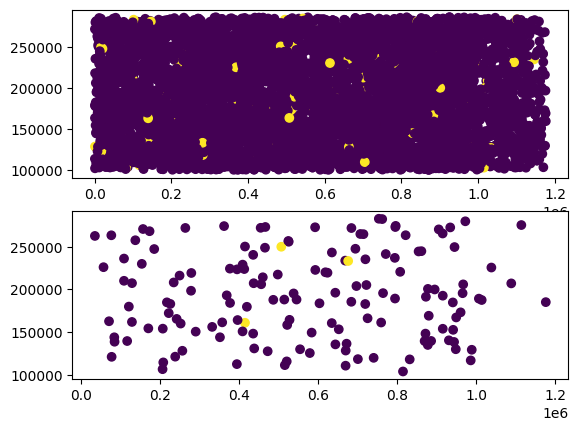

In [31]:
_, (ax1, ax2) = plt.subplots(2)
# Real data
scatter = ax1.scatter(Xy_true[:, 0], Xy_true[:, 1], c=Xy_true[:, -1])
# ax1.set(
#     xlabel=X_train.feature_names[0], ylabel=X_train.feature_names[1], xlim=(4, 8), ylim=(2, 4.5)
# )
# _ = ax1.legend(
#     scatter.legend_elements()[0], X_train.target_names, loc="lower right", title="Classes"
# )
# Fake data
scatter = ax2.scatter(Xy_fake[:, 0], Xy_fake[:, 1], c=Xy_fake[:, -1])
# ax2.set(
#     xlabel=X_train.feature_names[0], ylabel=X_train.feature_names[1], xlim=(4, 8), ylim=(2, 4.5)
# )
# _ = ax2.legend(
#     scatter.legend_elements()[0], X_train.target_names, loc="lower right", title="Classes"
# )

Explained variance ratio: [0.96798751 0.02759335]


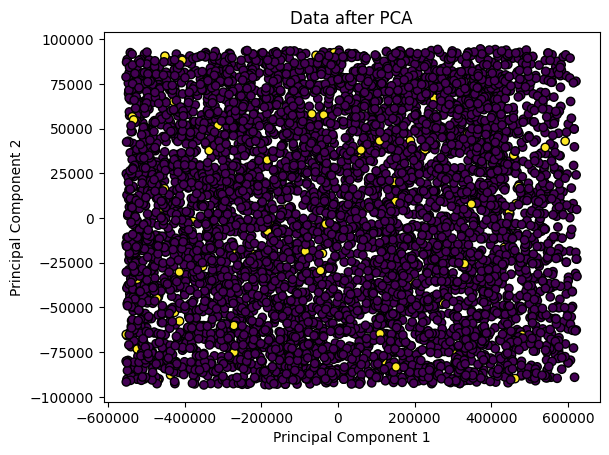

Explained variance ratio: [0.96545004 0.02965211]


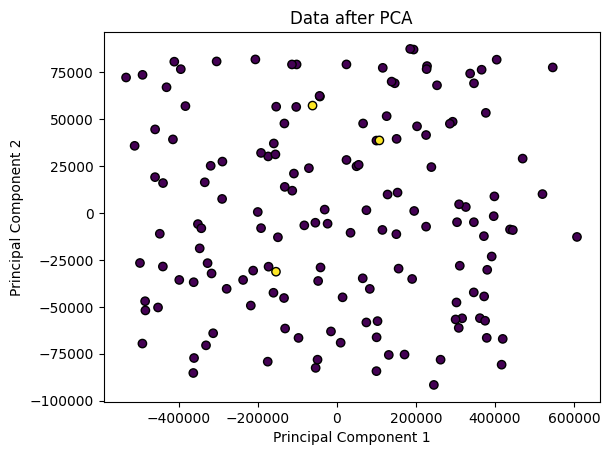

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs


# Perform PCA
pca = PCA(n_components=2)  # Adjust n_components for the desired dimensionality
X_pca = pca.fit_transform(Xy_true)

# Explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Visualize the PCA-transformed data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Xy_true[:, -1], cmap='viridis', edgecolor='k')
plt.title("Data after PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Perform PCA
pca = PCA(n_components=2)  # Adjust n_components for the desired dimensionality
X_pca = pca.fit_transform(Xy_fake)

# Explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Visualize the PCA-transformed data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Xy_fake[:, -1], cmap='viridis', edgecolor='k')
plt.title("Data after PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

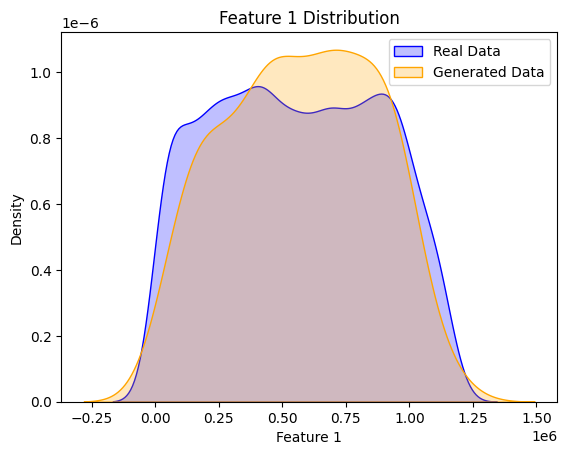

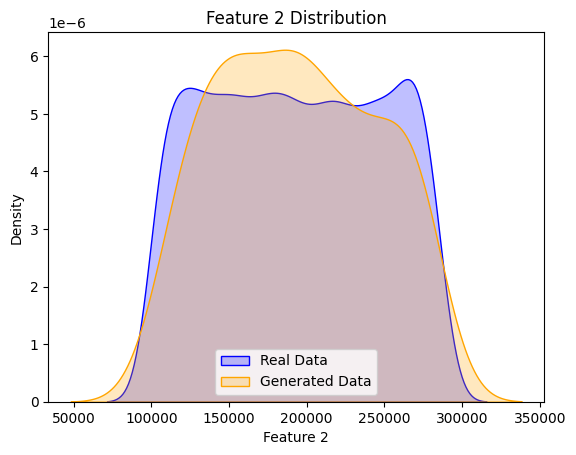

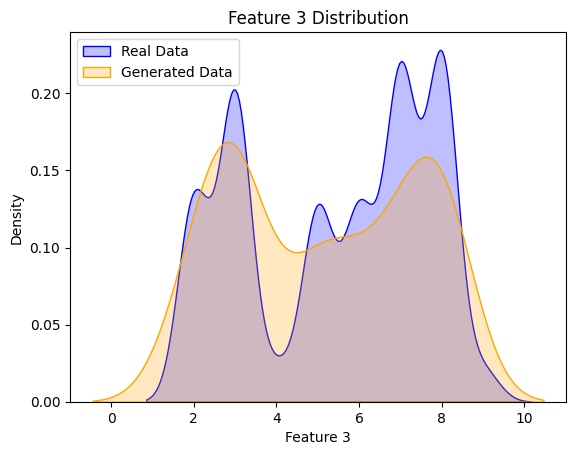

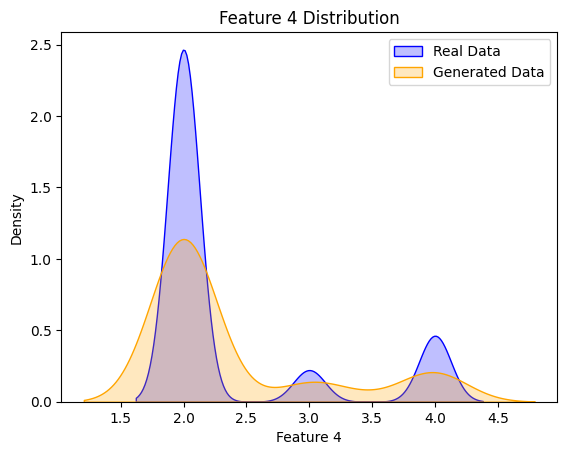

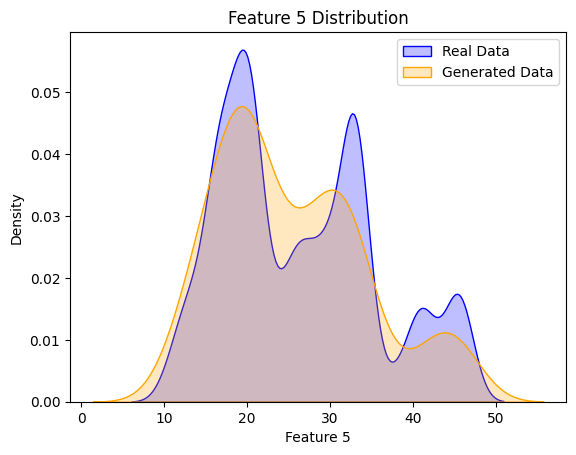

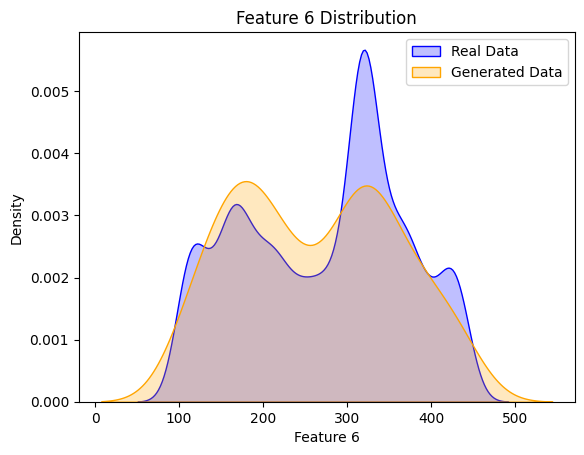

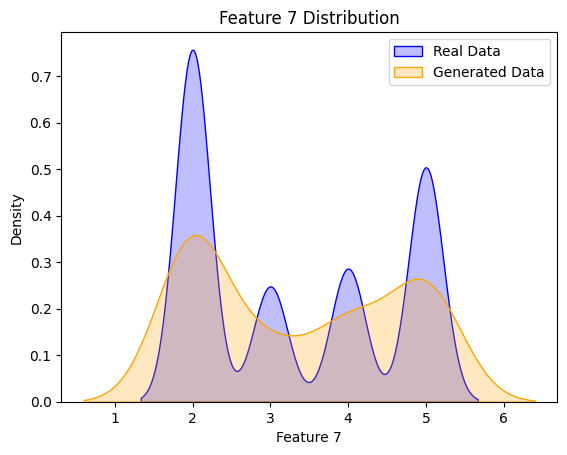

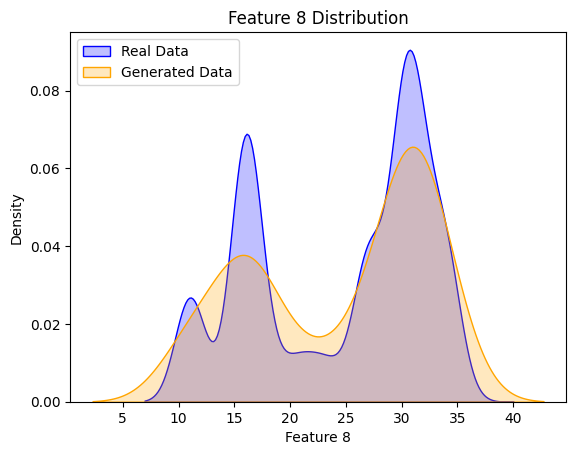

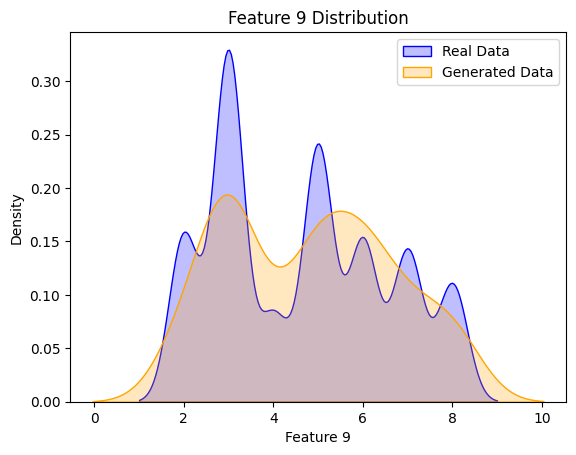

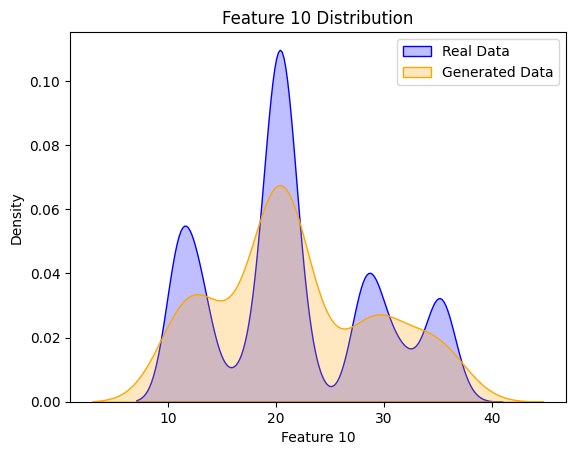

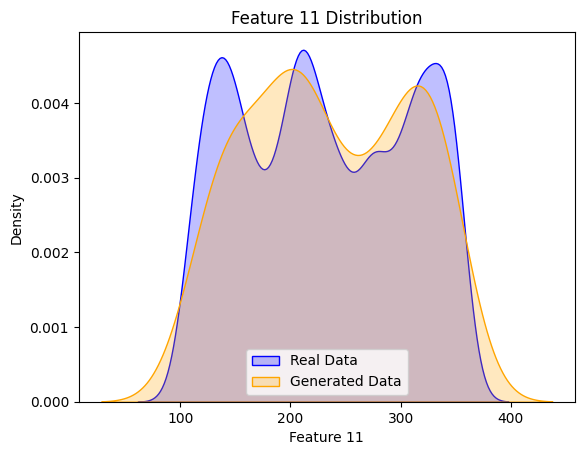

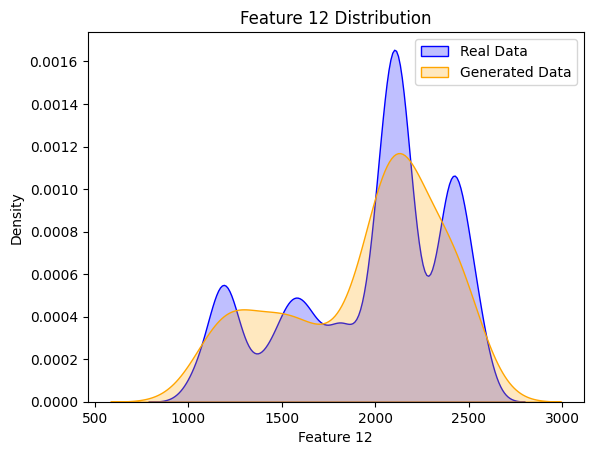

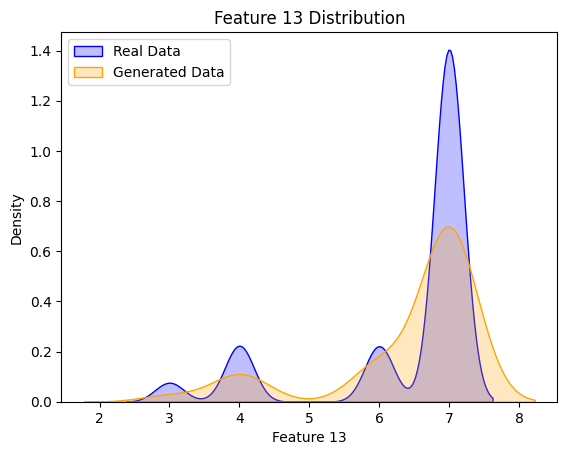

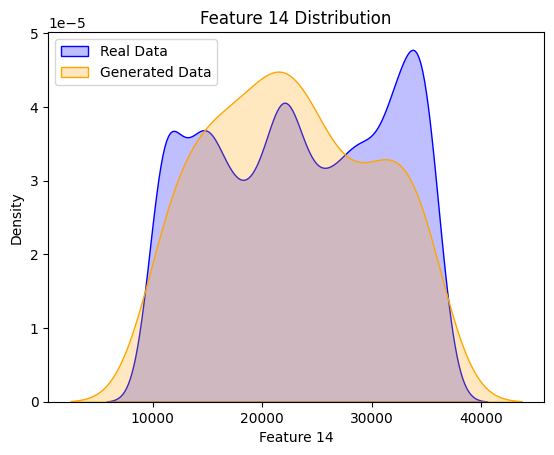

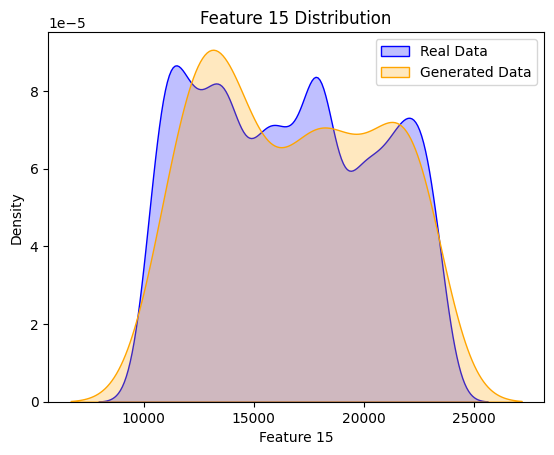

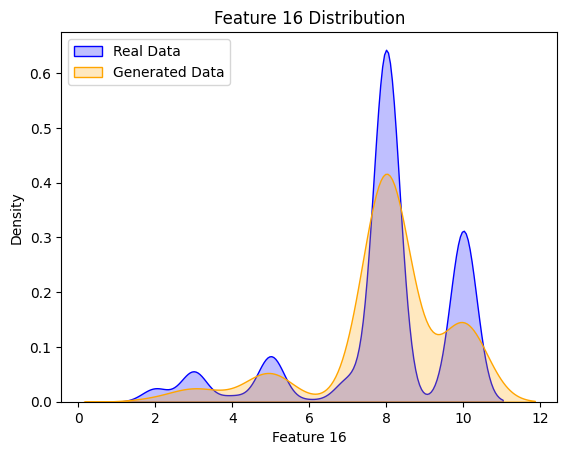

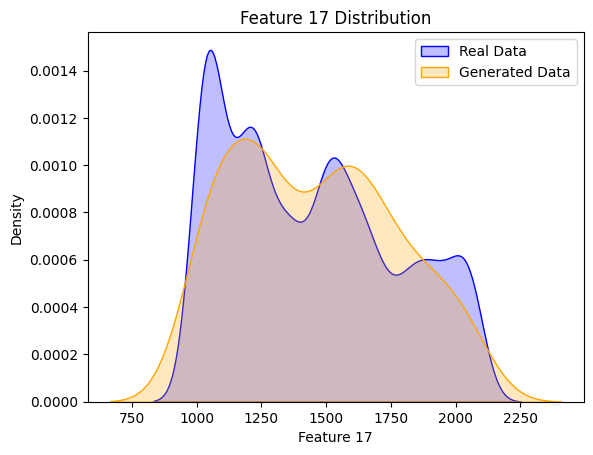

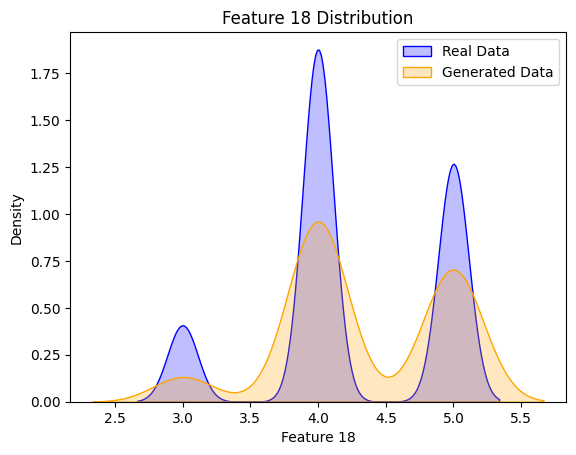

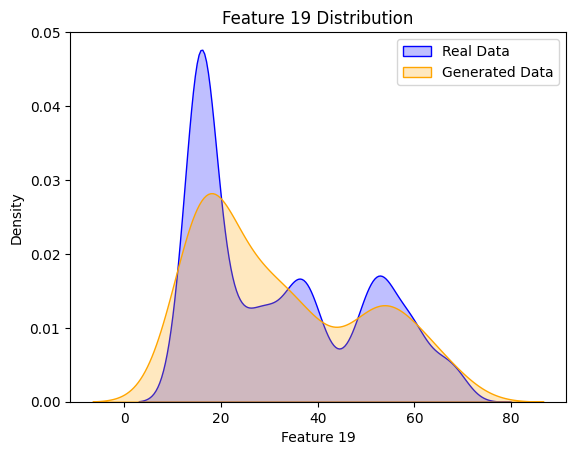

/var/folders/dm/9lc9wm652sl46vg0nsmrxh3w0000gn/T/ipykernel_52530/4111525177.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(Xy_true[:, i], label="Real Data", color="blue", fill=True)
/var/folders/dm/9lc9wm652sl46vg0nsmrxh3w0000gn/T/ipykernel_52530/4111525177.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(Xy_fake[:, i], label="Generated Data", color="orange", fill=True)
/var/folders/dm/9lc9wm652sl46vg0nsmrxh3w0000gn/T/ipykernel_52530/4111525177.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


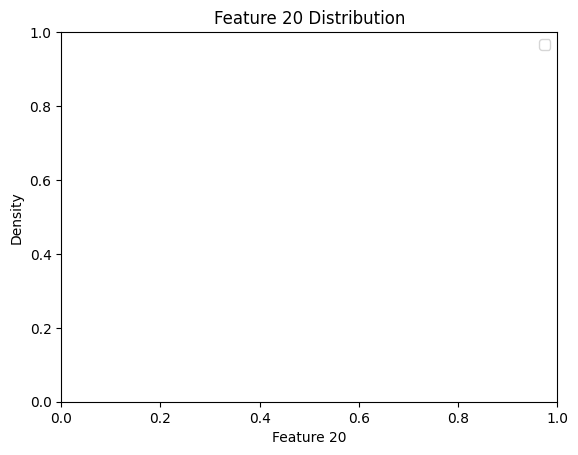

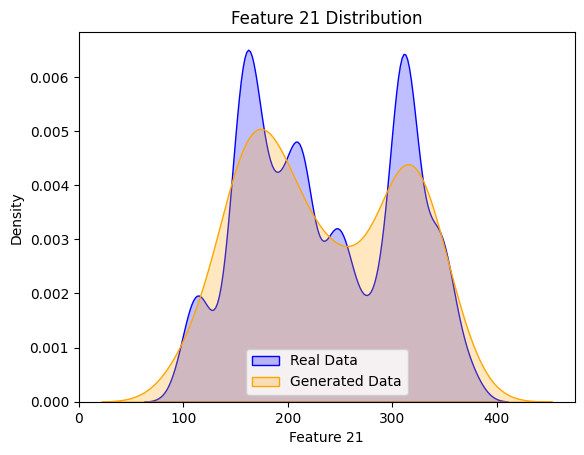

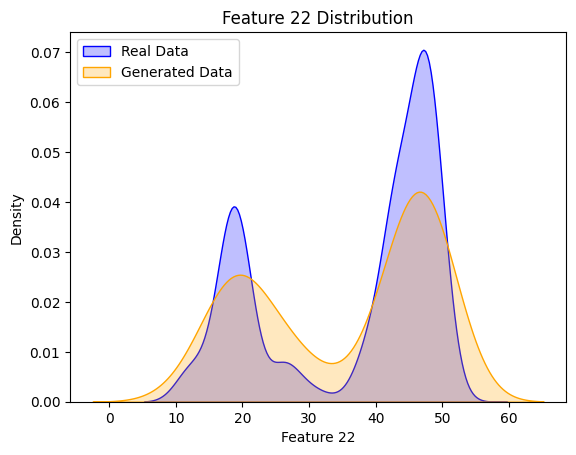

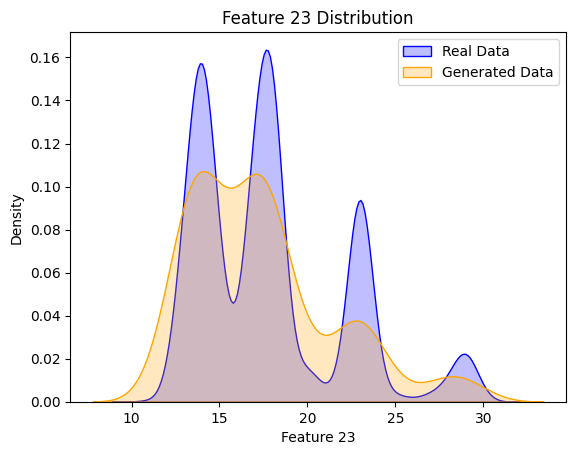

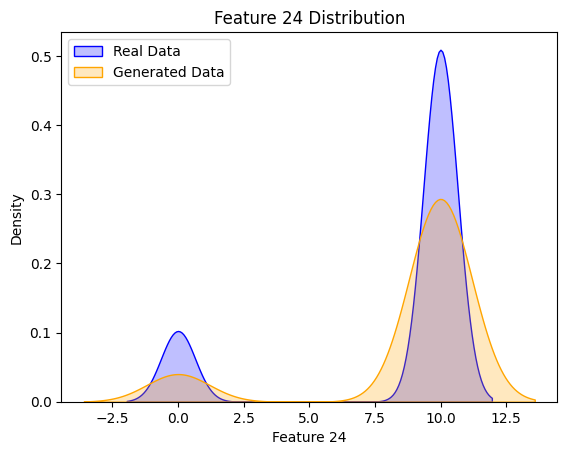

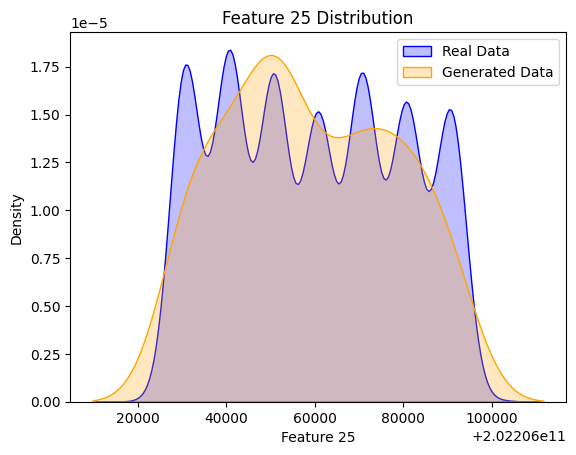

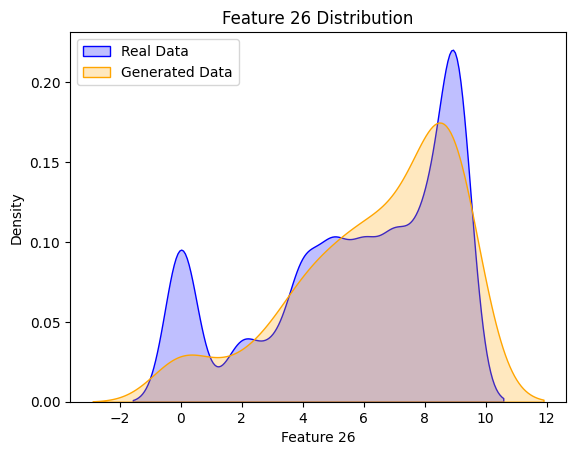

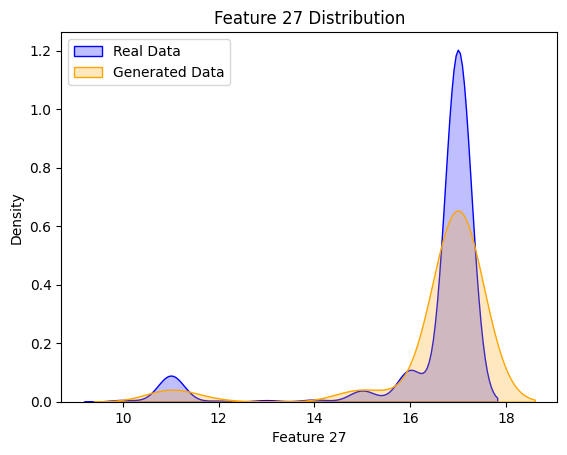

In [36]:
import seaborn as sns

# Visualize the distributions of each feature
for i in range(Xy_true.shape[1] - 1):  # Exclude the label column
    plt.figure()
    sns.kdeplot(Xy_true[:, i], label="Real Data", color="blue", fill=True)
    sns.kdeplot(Xy_fake[:, i], label="Generated Data", color="orange", fill=True)
    plt.title(f"Feature {i+1} Distribution")
    plt.xlabel(f"Feature {i+1}")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

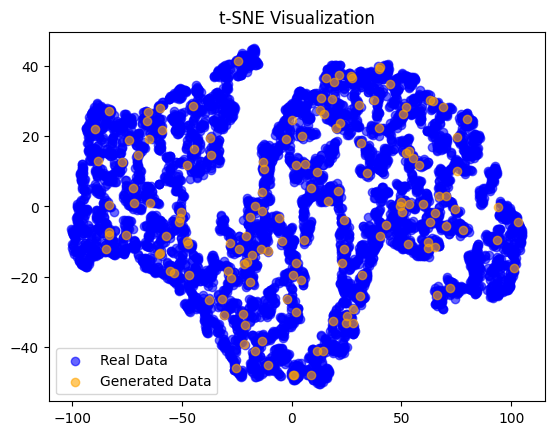

In [37]:
from sklearn.manifold import TSNE

# Concatenate real and generated data
combined_data = np.vstack((Xy_true[:, :-1], Xy_fake[:, :-1]))
combined_labels = np.hstack((np.zeros(Xy_true.shape[0]), np.ones(Xy_fake.shape[0])))

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(combined_data)

# Visualize
plt.scatter(data_2d[combined_labels == 0, 0], data_2d[combined_labels == 0, 1], 
            label="Real Data", alpha=0.6, color="blue")
plt.scatter(data_2d[combined_labels == 1, 0], data_2d[combined_labels == 1, 1], 
            label="Generated Data", alpha=0.6, color="orange")
plt.title("t-SNE Visualization")
plt.legend()
plt.show()

In [38]:
from scipy.stats import wasserstein_distance

# Compare each feature using Wasserstein distance
for i in range(Xy_true.shape[1] - 1):  # Exclude the label column
    distance = wasserstein_distance(Xy_true[:, i], Xy_fake[:, i])
    print(f"Wasserstein distance for Feature {i+1}: {distance}")

Wasserstein distance for Feature 1: 37608.41206898322
Wasserstein distance for Feature 2: 4317.600644996601
Wasserstein distance for Feature 3: 0.33704697506298464
Wasserstein distance for Feature 4: 0.03724127764705445
Wasserstein distance for Feature 5: 1.1002738504698926
Wasserstein distance for Feature 6: 11.908334376335358
Wasserstein distance for Feature 7: 0.054305864620542585
Wasserstein distance for Feature 8: 0.38455080230717764
Wasserstein distance for Feature 9: 0.19194775436428135
Wasserstein distance for Feature 10: 0.40643940211872026
Wasserstein distance for Feature 11: 4.824479615210811
Wasserstein distance for Feature 12: 32.39300840191576
Wasserstein distance for Feature 13: 0.06828419679567513
Wasserstein distance for Feature 14: 993.1914759666407
Wasserstein distance for Feature 15: 311.80415168158356
Wasserstein distance for Feature 16: 0.2496662983140207
Wasserstein distance for Feature 17: 29.96881743597301
Wasserstein distance for Feature 18: 0.0770463011169158

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Combine real and fake data with labels
X_combined = np.vstack((Xy_true[:100, :-1], Xy_fake[:100, :-1]))
y_combined = np.hstack((np.zeros(100), np.ones(100)))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
print("Classification Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Classification Accuracy: 0.8833333333333333
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.90        31
         1.0       0.96      0.79      0.87        29

    accuracy                           0.88        60
   macro avg       0.90      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



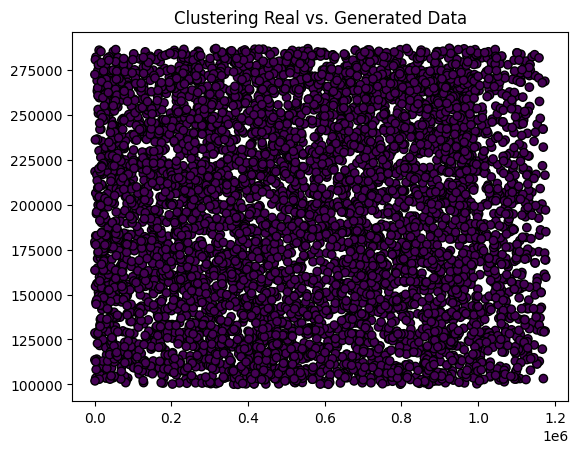

In [42]:
from sklearn.cluster import DBSCAN

# Cluster combined data
clustering = DBSCAN(eps=0.5, min_samples=10).fit(X_combined)
labels = clustering.labels_

# Visualize clustering
plt.scatter(X_combined[:, 0], X_combined[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.title("Clustering Real vs. Generated Data")
plt.show()

Below we show how to do the same with the [ForestDiffusion pip package](https://github.com/SamsungSAILMontreal/ForestDiffusion).

In [ ]:
# Load the datasets
feeds_df = pd.read_csv('/Users/callen/Data/digix-global-ai-challenge/versions/1/train/train_data_feeds.csv', sep=',')
ads_df = pd.read_csv('/Users/callen/Data/digix-global-ai-challenge/versions/1/train/train_data_ads.csv', sep=',')

# Convert the 'i_docId' and 'adv_id' columns to strings before merging
# feeds_df['i_docId'] = feeds_df['i_docId'].astype(str)
# ads_df['adv_id'] = ads_df['adv_id'].astype(str)

# # Merge the datasets based on document IDs
# common_doc_ids = pd.merge(feeds_df[['i_docId']], ads_df[['adv_id']], left_on='i_docId', right_on='adv_id')

# Select important features for modeling
selected_features_df = ads_df[[
    "log_id",
    "label",
    "user_id",
    "age",
    "gender",
    "residence",
    "city",
    "city_rank",
    "series_dev",
    "series_group",
    "emui_dev",
    "device_name",
    "device_size",
    "net_type",
    "task_id",
    "adv_id",
    "creat_type_cd",
    "adv_prim_id",
    "inter_type_cd",
    "slot_id",
    "site_id",
    "spread_app_id",
    "hispace_app_tags",
    "app_second_class",
    "app_score",
    "pt_d",
    "u_refreshTimes",
    "u_feedLifeCycle"
]]

# Step 1: Split the data into training and test sets
X = selected_features_df.drop(columns=['label'])  # Features
y = selected_features_df['label']  # Target
# Split into training and test sets (80% training, 20% testing)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Apply under-sampling to the training set to balance classes (ensure feature-label correspondence)
train_concat_class_0 = pd.concat([X_train_full[y_train_full == 0], y_train_full[y_train_full == 0]], axis=1)  # Combine features and labels
train_concat_class_1 = pd.concat([X_train_full[y_train_full == 1], y_train_full[y_train_full == 1]], axis=1)

# Sample from both classes (features + labels together)
train_sampled_class_1 = train_concat_class_1.sample(frac=0.1)  # Under-sample class 1
train_sampled_class_0 = train_concat_class_0.sample(frac=0.1)  # Under-sample class 0
# train_sampled_class_1 = train_concat_class_1.sample(80000)  # Under-sample class 1

# Concatenate sampled data from both classes
train_ads = pd.concat([train_sampled_class_0, train_sampled_class_1], axis=0)

# Shuffle the combined training data
train_ads = train_ads.sample(frac=0.01).reset_index(drop=True)

# Separate the features (X) and labels (y) after sampling
X_train = train_ads.drop(columns=['label'])  # Features for training
y_train = train_ads['label']  # Corresponding labels for training

In [ ]:
%%time
from ForestDiffusion import ForestDiffusionModel as ForestFlowModel
forest_model = ForestFlowModel(
    X_train.to_numpy(),
    label_y=y_train.to_numpy(),
    n_t=50,
    duplicate_K=100,
    bin_indexes=[],
    cat_indexes=[],
    int_indexes=[],
    diffusion_type="flow",
    n_jobs=-1,
    seed=1,
)
Xy_fake_ = forest_model.generate(batch_size=X.shape[0])

In [ ]:
_, (ax1, ax2) = plt.subplots(2)
# Real data
scatter = ax1.scatter(Xy_true[:, 0], Xy_true[:, 1], c=Xy_true[:, -1])
ax1.set(
    xlabel=my_data.feature_names[0], ylabel=my_data.feature_names[1], xlim=(4, 8), ylim=(2, 4.5)
)
_ = ax1.legend(
    scatter.legend_elements()[0], my_data.target_names, loc="lower right", title="Classes"
)
# Fake data
scatter = ax2.scatter(Xy_fake_[:, 0], Xy_fake_[:, 1], c=Xy_fake_[:, -1])
ax2.set(
    xlabel=my_data.feature_names[0], ylabel=my_data.feature_names[1], xlim=(4, 8), ylim=(2, 4.5)
)
_ = ax2.legend(
    scatter.legend_elements()[0], my_data.target_names, loc="lower right", title="Classes"
)